# An analysis of different neural network classification algorithms for identifying foetal wellbeing

- Ibeawuchi Ogbedeleto (s5131337@bournemouth.ac.uk)
- Anne Rutherford (s5130945@bournemouth.ac.uk)
- Ben Snow (bsnow@bournemouth.ac.uk)


## Introduction and problem definition

A Cardiotocography (CTG) is a scan used by medical professionals to measure the foetal heartrate and mother's uterine contractions during pregnancy. CTG scans are performed to gain insight into the wellbeing of the unborn foetus.

In this project, an attempt is made to create a three class, neural network classifier to identify foetal status from a data set of diagnostic features. The status of the foetus is either N, S or P: Normal, Suspect or Pathologic. The dataset includes information from 2126 Cardiotocograms that measure foetal heartrate and uterine contractions. The dataset can be found [here.](https://archive.ics.uci.edu/ml/datasets/cardiotocography)

Hypothesis: A multilayer perceptron classifier's performance measured by sensitivity and precision on the 'NSP' class in the CTG dataset is affected by the activation function in the hidden layers.

- Null hypothesis H<sub>0</sub> : Not enough evidence to support the hypothesis.

- Alternative hypothesis H<sub>1</sub> : Evidence found indicating the hypothesis is true.

- The null hypothesis will be tested at the 5% significance level.

Accuracy is not a good performance measure for an imbalanced datset as simply predicting all babies as normal will give high accuracy.


**Performance metrics**. Sensitivity (also known as recall) is a measure we use as it measures the extent to which we avoid false negatives. This measure has been chosen as it is important to avoid missing babies who are pathologic or abnormal, and each false negative represents a pathologic/abnormal baby missed by the classifier.
$$Sensitivity = \frac{Tp}{Tp+Fn}$$
Precision is another measure of performance which measures the proportion of predicted positive values that were actually positive. This measures the extent to which we avoid false positives. This is important as we would like our model not to miss sick babies (sensitivity) but also provide good predictions, we don't want the model to be overcautious and predict every baby is pathologic/abnormal. In practical terms if the model is not precise it will be hard to use as medical staff will start to ignore predictions if there are too many false positives.
 $$Precision = \frac{Tp}{Tp+Fp}$$


### Importing useful libraries

In [1]:
import numpy as np                                     # linear algebra
import pandas as pd                                    # data processing
from   pandas import DataFrame, read_csv               # data structures and csv reading
import matplotlib.pyplot as plt                        # for plotting
import tensorflow as tf                                # dataflow programming
from   tensorflow import keras                         # neural networks API
from   sklearn.model_selection import train_test_split # dataset splitting
from   imblearn.over_sampling import ADASYN            # for oversampling
import plotly.graph_objects as go                      # for data visualisation
import plotly.io as pio                                # to set shahin plot layout
import os
from sklearn import preprocessing                      # for standardisation of data

## Preprocessing

### Reading data into appropriate structures

After examining the CTG.xls dataset in Microsoft Excel it was found that there were some null columns and missing data. In the following cell data is read in from the dataset omiting null columns and rows.

In [2]:
### specification of data location ###
url_dataset = "https://archive.ics.uci.edu/ml/machine-learning-databases/00193/CTG.xls"

### Detection and removal of NaN collumns and rows ###
df_data     =  pd.read_excel(url_dataset, sheet_name="Data", header=1)                   # reading from 'data' sheet in the xls flie to a dataframe
first_row_with_all_NaN = df_data[df_data.isnull().all(axis=1) == True].index.tolist()[0] # find first fully null row
df_data = df_data.loc[0:first_row_with_all_NaN-1]                                        # remove any rows after the first all null row
df_data = df_data.dropna(axis=1,how='all')                                               # remove any null collumns

### Reading 'Raw Data' sheet cleaning ###
df_raw_data = pd.read_excel(url_dataset, sheet_name="Raw Data", header=1)
df_raw_data = df_raw_data.dropna()
df_raw_data=df_raw_data.dropna(axis=1,how='all')

## ***Data imbalance***

It can be seen from the graph below that the 'NSP' class is imbalanced. There is a 78% data imbalance in favour of class 1. Training a model with this dataset can cause the model to learn mainly from the majority class. This can also lead to overfitting of the model.

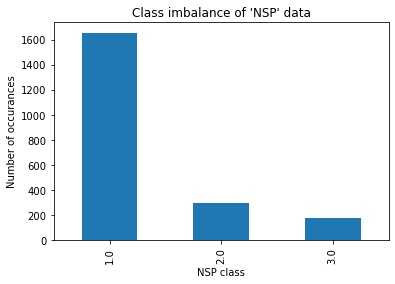

In [3]:
ax = df_data['NSP'].value_counts().plot.bar()   # defining a bar plot of the number of occurances of a given class
ax.set_xlabel("NSP class")                      # axis labels and plot title
ax.set_ylabel("Number of occurances")
ax.set_title("Class imbalance of 'NSP' data")
no_class_one = df_data['NSP'].value_counts(0)
total = no_class_one[1.0] + no_class_one[2.0] + no_class_one[3.0]
imbalance_percent = round(((no_class_one[1.0]*100)/(total)),2)

### Standardisation

Standardising data enables data comparison on different scales and centre around 0, mean = 0, standard dev = 1, normalising means outliers can distort data.

  This is a mapping of data to the unit gaussian distribution relevant due to the differing ranges of input data across the features (e.g. baseline value goes from 106-160 whereas mean value of short term variability (MTSV) ranges from 0.2-7) This technique is known to increase learning effectiveness when training Neural Networks's https://bit.ly/2DouAxm

In [4]:
columns = ['LB', 'AC.1', 'FM.1', 'UC.1', 'DL.1', 'DS.1', 'DP.1', 'ASTV',        # defining the list of features used by an expert to determine the 'NSP' class
           'MSTV', 'ALTV', 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros',
           'Mode', 'Mean', 'Median', 'Variance', 'Tendency']

labels_pre_split = df_data['NSP']              # defining 'NSP' labels into a data frame (prior to test/train separation)
features_pre_split = df_data[columns]          # defining features

### Standardisation of feature data ###
scaler = preprocessing.StandardScaler()        # defining a scaler object on which to project standardised data
scaled_feature_data = scaler.fit_transform(features_pre_split)
features_pre_split = pd.DataFrame(scaled_feature_data, columns=columns)

### Splitting into training, validation and testing data

In order to reduce the effects of this data imbalance a popular upsampling technique called ADAptive SYNthetic oversampling, ADASYN, is used. ADASYN uses the minority classes in a dataset and to generate new, similar data for those classes.

Oversampling is prefered to undersampling in this experiment due to the small number of datapoints available in the CTG dataset. Also undersampling may lead to data loss which is a problem due to scarcity of data from group 3. Oversampling restores balance between the classes shown in the bar chart.

Before implementing ADASYN it is necessary to first split the dataset into training, validation and testing datasets. This is because validation and testing data must be real world data that has not been synthetically generated to give an objective measure of performance.

First data is split 70:30 into training and testing sets. The testing set is then metaphorically 'locked away' to prevent it ever being used for training. Once the test data has been used it becomes part of the modelling process introducing the likelihood of the model being overfitted and losing predictive power and being less able to genaralise to eal life data. 

After this, the training data is split 70:30 into training and validation data. The validation data was available to use for testing any amended models and avoid using the test set.


Text(0.5, 1.0, 'Effect of ADASYN oversampling on class imbalance')

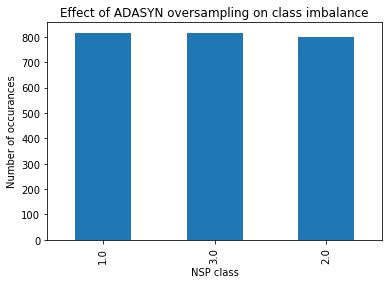

In [5]:
### Extracting testing and training data ###
features_train, features_test, labels_train, labels_test = train_test_split(features_pre_split,labels_pre_split,test_size=0.3,random_state=0)   # 70/30 training/testing splitting performed randomly

features_true_train, features_validation, labels_true_train, labels_validation = train_test_split(features_train,labels_train,test_size=0.3,random_state=0) # 70/30 training/validation splitting of the initial training data

features_resampled_true_train, labels_resampled_true_train = ADASYN().fit_sample(features_true_train, labels_true_train)  # oversampling of the training dataset

features_resampled_true_train = pd.DataFrame(features_resampled_true_train, columns=[columns])    # storing features and labels in dataframes
labels_resampled_true_train = pd.DataFrame(labels_resampled_true_train, columns=['NSP'])

### Plot to show the effect of oversampling e.g. restored class balance. ###
ax = labels_resampled_true_train['NSP'].value_counts().plot.bar()
ax.set_xlabel("NSP class")
ax.set_ylabel("Number of occurances")
ax.set_title("Effect of ADASYN oversampling on class imbalance")

### One hot encoding of labelled data

Since the data in the NSP column is categorical we need to convert it into an integer form so it can be used in neural network training. This is called one hot encoding and is performed below.

In [6]:
## training cat codes
labels_cat_codes_train = labels_resampled_true_train['NSP'].astype('category').cat.codes        # convert the NSP to categories (instead of doubles)
labels_cat_one_hot_train = keras.utils.to_categorical(labels_cat_codes_train,num_classes=None)  # one hot encoding

## validation cat codes
labels_cat_codes_val = labels_validation.astype('category').cat.codes
labels_cat_one_hot_val = keras.utils.to_categorical(labels_cat_codes_val,num_classes=None)

## testing cat codes
labels_cat_codes_test = labels_test.astype('category').cat.codes
labels_cat_one_hot_test = keras.utils.to_categorical(labels_cat_codes_test,num_classes=None)


## ***Model Building***

## Perceptron model building

Here a function to create simple multilayer perceptrons optimised by the ADAM optimiser is constructed. This ensures that each of the neural networks created have the same architecture. A simple architecture is used to keep compilation, training and testing times low.
The exact same architecture for each examined network will be used. A diagram of this can be seen here: ![Hello](https://i.imgur.com/0j8kPkZ.png)

In [7]:
def perceptron_builder(input_dim_, output_dim_, number_hidden_layers_, hidden_activation_, output_activation_):
  model = keras.Sequential()
  model.add(keras.layers.Dense(21, input_shape=(input_dim_,), activation = hidden_activation_))
  for i in range (number_hidden_layers_-1):
    model.add(keras.layers.Dense(21, activation = hidden_activation_))
  
  model.add(keras.layers.Dense(3, activation = output_activation_))
  model.compile(keras.optimizers.Adam(), 'categorical_crossentropy', metrics=['accuracy'],)
  return model


## Training and validation functions

Models will be trained with the same training data and then will be validated with the same validation data.

In [8]:
def model_train(model_, input_data_, labelled_data_, epochs_, verbose_):
  return model_.fit(input_data_, labelled_data_, epochs = epochs_, verbose = verbose_)
 
def model_validate(model_, test_features_, test_labels_):
  return model_.evaluate(test_features_, test_labels_)[1]
      


## Generation of different models

Three different activation functions are specified: tanh, relu & sigmoid. Tanh and sigmoid were chosen for their step like features with different gradients within limits and relu as it tends to activate more sparsely and be more computationally efficient. The independent variable, therefore, in this experiment is the activation function in the hidden layers of the neural networks. Models are generated, trained and stored together in a data dictionary.

Sampling: for our experiment we have chosen a sample size of 10 to calculate mean sensitivity and precision rates as this is commonly used since it is high enough to give a reasonable value without taking too long. We ideally would use 30 but this caused the notebook to crash.

In [9]:
activation_funs = ['tanh', 'relu', 'sigmoid'] # edit this list to change the number of activation functions (e.g. number of models to train)
number_of_models = 11
## Initialising data dictionary
dict_of_perceptrons={};
for i in activation_funs:
    dict_of_perceptrons[i]={}
for i in activation_funs:
  for j in range (1,number_of_models):
    dict_of_perceptrons[i][j]={}

In [ ]:
for i in range(len(activation_funs)):
  for j in range(1,number_of_models):
    perceptron = perceptron_builder(21, 3, 4, activation_funs[i], 'softmax')               # building a perceptron model
    model_train(perceptron, features_resampled_true_train, labels_cat_one_hot_train, 100, 1) # training the perceptron
    if i == 0:
      function_name = 'tanh'
    elif i == 1:
      function_name = 'relu'
    elif i == 2:
      function_name = 'sigmoid'
    dict_of_perceptrons[function_name][j] = perceptron ## storing the perceptron models in a data dictionary

Train on 2431 samples
Epoch 1/100
2431/2431 [==============================] - 3s 1ms/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 2/100
2431/2431 [==============================] - 0s 101us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 3/100
2431/2431 [==============================] - 0s 96us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 4/100
2431/2431 [==============================] - 0s 94us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 5/100
2431/2431 [==============================] - 0s 94us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 6/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 7/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 8/100
2431/2431 [==============================] - 0s 88us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 9/100
2431/2431 [==============================] - 0s 88us/sample - loss: 1.1921e-07 - accur

2431/2431 [==============================] - 0s 84us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 74/100
2431/2431 [==============================] - 0s 84us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 75/100
2431/2431 [==============================] - 0s 87us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 76/100
2431/2431 [==============================] - 0s 88us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 77/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 78/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 79/100
2431/2431 [==============================] - 0s 84us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 80/100
2431/2431 [==============================] - 0s 83us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 81/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 82/100
2

2431/2431 [==============================] - 0s 85us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 18/100
2431/2431 [==============================] - 0s 90us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 19/100
2431/2431 [==============================] - 0s 84us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 20/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 21/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 22/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 23/100
2431/2431 [==============================] - 0s 83us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 24/100
2431/2431 [==============================] - 0s 88us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 25/100
2431/2431 [==============================] - 0s 87us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 26/100
2

2431/2431 [==============================] - 0s 91us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 63/100
2431/2431 [==============================] - 0s 91us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 64/100
2431/2431 [==============================] - 0s 93us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 65/100
2431/2431 [==============================] - 0s 91us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 66/100
2431/2431 [==============================] - 0s 110us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 67/100
2431/2431 [==============================] - 0s 100us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 68/100
2431/2431 [==============================] - 0s 107us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 69/100
2431/2431 [==============================] - 0s 91us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 70/100
2431/2431 [==============================] - 0s 101us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 71/1

2431/2431 [==============================] - 0s 99us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 35/100
2431/2431 [==============================] - 0s 106us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 36/100
2431/2431 [==============================] - 0s 87us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 37/100
2431/2431 [==============================] - 0s 104us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 38/100
2431/2431 [==============================] - 0s 88us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 39/100
2431/2431 [==============================] - 0s 103us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 40/100
2431/2431 [==============================] - 0s 92us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 41/100
2431/2431 [==============================] - 0s 88us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 42/100
2431/2431 [==============================] - 0s 86us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 43/10

2431/2431 [==============================] - 0s 87us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 80/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 81/100
2431/2431 [==============================] - 0s 87us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 82/100
2431/2431 [==============================] - 0s 91us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 83/100
2431/2431 [==============================] - 0s 80us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 84/100
2431/2431 [==============================] - 0s 81us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 85/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 86/100
2431/2431 [==============================] - 0s 83us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 87/100
2431/2431 [==============================] - 0s 84us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 88/100
2

2431/2431 [==============================] - 0s 89us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 24/100
2431/2431 [==============================] - 0s 80us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 25/100
2431/2431 [==============================] - 0s 88us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 26/100
2431/2431 [==============================] - 0s 83us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 27/100
2431/2431 [==============================] - 0s 94us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 28/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 29/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 30/100
2431/2431 [==============================] - 0s 93us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 31/100
2431/2431 [==============================] - 0s 87us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 32/100
2

2431/2431 [==============================] - 0s 80us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 69/100
2431/2431 [==============================] - 0s 80us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 70/100
2431/2431 [==============================] - 0s 79us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 71/100
2431/2431 [==============================] - 0s 79us/sample - loss: 1.1921e-07 - accuracy: 0.3357s - loss: 1.1921e-07 - accuracy: 0.34
Epoch 72/100
2431/2431 [==============================] - 0s 80us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 73/100
2431/2431 [==============================] - 0s 80us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 74/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 75/100
2431/2431 [==============================] - 0s 81us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 76/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.1921e

2431/2431 [==============================] - 0s 88us/sample - loss: 1.0987 - accuracy: 0.3357
Epoch 12/100
2431/2431 [==============================] - 0s 87us/sample - loss: 1.0987 - accuracy: 0.3324
Epoch 13/100
2431/2431 [==============================] - 0s 83us/sample - loss: 1.0987 - accuracy: 0.3204
Epoch 14/100
2431/2431 [==============================] - 0s 80us/sample - loss: 1.0987 - accuracy: 0.3357
Epoch 15/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.0987 - accuracy: 0.3324
Epoch 16/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.0986 - accuracy: 0.3237
Epoch 17/100
2431/2431 [==============================] - 0s 81us/sample - loss: 1.0986 - accuracy: 0.3287
Epoch 18/100
2431/2431 [==============================] - 0s 94us/sample - loss: 1.0987 - accuracy: 0.3233
Epoch 19/100
2431/2431 [==============================] - 0s 126us/sample - loss: 1.0987 - accuracy: 0.3262
Epoch 20/100
2431/2431 [=========================

2431/2431 [==============================] - 0s 84us/sample - loss: 1.0987 - accuracy: 0.3357
Epoch 62/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.0987 - accuracy: 0.3229
Epoch 63/100
2431/2431 [==============================] - ETA: 0s - loss: 1.0985 - accuracy: 0.34 - 0s 84us/sample - loss: 1.0987 - accuracy: 0.3340
Epoch 64/100
2431/2431 [==============================] - 0s 80us/sample - loss: 1.0987 - accuracy: 0.3221
Epoch 65/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.0986 - accuracy: 0.3357
Epoch 66/100
2431/2431 [==============================] - 0s 84us/sample - loss: 1.0987 - accuracy: 0.3221
Epoch 67/100
2431/2431 [==============================] - 0s 83us/sample - loss: 1.0986 - accuracy: 0.3184
Epoch 68/100
2431/2431 [==============================] - 0s 84us/sample - loss: 1.0987 - accuracy: 0.3365
Epoch 69/100
2431/2431 [==============================] - 0s 83us/sample - loss: 1.0987 - accuracy: 0.3357
Epoch 70

2431/2431 [==============================] - 0s 99us/sample - loss: 1.0986 - accuracy: 0.3332
Epoch 36/100
2431/2431 [==============================] - 0s 98us/sample - loss: 1.0987 - accuracy: 0.3357
Epoch 37/100
2431/2431 [==============================] - 0s 94us/sample - loss: 1.0987 - accuracy: 0.3303
Epoch 38/100
2431/2431 [==============================] - 0s 92us/sample - loss: 1.0987 - accuracy: 0.3348
Epoch 39/100
2431/2431 [==============================] - 0s 89us/sample - loss: 1.0986 - accuracy: 0.3225
Epoch 40/100
2431/2431 [==============================] - 0s 99us/sample - loss: 1.0987 - accuracy: 0.3357
Epoch 41/100
2431/2431 [==============================] - 0s 96us/sample - loss: 1.0987 - accuracy: 0.3357
Epoch 42/100
2431/2431 [==============================] - 0s 92us/sample - loss: 1.0986 - accuracy: 0.3357
Epoch 43/100
2431/2431 [==============================] - 0s 95us/sample - loss: 1.0987 - accuracy: 0.3266
Epoch 44/100
2431/2431 [==========================

2431/2431 [==============================] - 0s 82us/sample - loss: 1.0987 - accuracy: 0.3357
Epoch 86/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.0986 - accuracy: 0.3357
Epoch 87/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.0987 - accuracy: 0.3287
Epoch 88/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.0987 - accuracy: 0.3274
Epoch 89/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.0986 - accuracy: 0.3357
Epoch 90/100
2431/2431 [==============================] - 0s 84us/sample - loss: 1.0987 - accuracy: 0.3274
Epoch 91/100
2431/2431 [==============================] - 0s 84us/sample - loss: 1.0987 - accuracy: 0.3250
Epoch 92/100
2431/2431 [==============================] - 0s 83us/sample - loss: 1.0987 - accuracy: 0.3237
Epoch 93/100
2431/2431 [==============================] - 0s 87us/sample - loss: 1.0987 - accuracy: 0.3357
Epoch 94/100
2431/2431 [==========================

2431/2431 [==============================] - 0s 87us/sample - loss: 1.0986 - accuracy: 0.3357
Epoch 34/100
2431/2431 [==============================] - 0s 86us/sample - loss: 1.0986 - accuracy: 0.3357
Epoch 35/100
2431/2431 [==============================] - 0s 83us/sample - loss: 1.0986 - accuracy: 0.3274
Epoch 36/100
2431/2431 [==============================] - 0s 89us/sample - loss: 1.0987 - accuracy: 0.3357
Epoch 37/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.0987 - accuracy: 0.3217
Epoch 38/100
2431/2431 [==============================] - 0s 81us/sample - loss: 1.0987 - accuracy: 0.3357
Epoch 39/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.0987 - accuracy: 0.3357
Epoch 40/100
2431/2431 [==============================] - 0s 92us/sample - loss: 1.0986 - accuracy: 0.3283
Epoch 41/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.0987 - accuracy: 0.3307
Epoch 42/100
2431/2431 [==========================

2431/2431 [==============================] - 0s 85us/sample - loss: 1.0987 - accuracy: 0.3250
Epoch 84/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.0986 - accuracy: 0.3311
Epoch 85/100
2431/2431 [==============================] - 0s 83us/sample - loss: 1.0987 - accuracy: 0.3241
Epoch 86/100
2431/2431 [==============================] - 0s 89us/sample - loss: 1.0987 - accuracy: 0.3102
Epoch 87/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.0987 - accuracy: 0.3328
Epoch 88/100
2431/2431 [==============================] - 0s 83us/sample - loss: 1.0987 - accuracy: 0.3278
Epoch 89/100
2431/2431 [==============================] - 0s 89us/sample - loss: 1.0987 - accuracy: 0.3328
Epoch 90/100
2431/2431 [==============================] - 0s 83us/sample - loss: 1.0986 - accuracy: 0.3118
Epoch 91/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.0987 - accuracy: 0.3221
Epoch 92/100
2431/2431 [==========================

Epoch 58/100
2431/2431 [==============================] - 0s 81us/sample - loss: 1.0987 - accuracy: 0.3357
Epoch 59/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.0986 - accuracy: 0.3357
Epoch 60/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.0987 - accuracy: 0.3357
Epoch 61/100
2431/2431 [==============================] - 0s 81us/sample - loss: 1.0987 - accuracy: 0.3262
Epoch 62/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.0987 - accuracy: 0.3278
Epoch 63/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.0987 - accuracy: 0.3278
Epoch 64/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.0988 - accuracy: 0.3254
Epoch 65/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.0987 - accuracy: 0.3369
Epoch 66/100
2431/2431 [==============================] - 0s 83us/sample - loss: 1.0986 - accuracy: 0.3241
Epoch 67/100
2431/2431 [=============

2431/2431 [==============================] - 0s 83us/sample - loss: 1.0986 - accuracy: 0.3258
Epoch 7/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.0987 - accuracy: 0.3357
Epoch 8/100
2431/2431 [==============================] - 0s 83us/sample - loss: 1.0987 - accuracy: 0.3270
Epoch 9/100
2431/2431 [==============================] - 0s 81us/sample - loss: 1.0987 - accuracy: 0.3291
Epoch 10/100
2431/2431 [==============================] - 0s 80us/sample - loss: 1.0987 - accuracy: 0.3299
Epoch 11/100
2431/2431 [==============================] - 0s 80us/sample - loss: 1.0987 - accuracy: 0.3225
Epoch 12/100
2431/2431 [==============================] - 0s 80us/sample - loss: 1.0986 - accuracy: 0.3357
Epoch 13/100
2431/2431 [==============================] - 0s 81us/sample - loss: 1.0987 - accuracy: 0.3357
Epoch 14/100
2431/2431 [==============================] - 0s 80us/sample - loss: 1.0987 - accuracy: 0.3357
Epoch 15/100
2431/2431 [=============================

Epoch 55/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 56/100
2431/2431 [==============================] - 0s 80us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 57/100
2431/2431 [==============================] - 0s 78us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 58/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 59/100
2431/2431 [==============================] - 0s 78us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 60/100
2431/2431 [==============================] - 0s 80us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 61/100
2431/2431 [==============================] - 0s 80us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 62/100
2431/2431 [==============================] - 0s 83us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 63/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.1921e-07 - accuracy: 0.3357
E

2431/2431 [==============================] - 0s 79us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 100/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Train on 2431 samples
Epoch 1/100
2431/2431 [==============================] - 0s 111us/sample - loss: 1.1142 - accuracy: 0.3172
Epoch 2/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 3/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 4/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 5/100
2431/2431 [==============================] - 0s 80us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 6/100
2431/2431 [==============================] - 0s 78us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 7/100
2431/2431 [==============================] - 0s 81us/sample - loss: 1.1921e-07 - accuracy: 0.3357
E

2431/2431 [==============================] - 0s 84us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 44/100
2431/2431 [==============================] - 0s 81us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 45/100
2431/2431 [==============================] - 0s 84us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 46/100
2431/2431 [==============================] - 0s 87us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 47/100
2431/2431 [==============================] - 0s 89us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 48/100
2431/2431 [==============================] - 0s 86us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 49/100
2431/2431 [==============================] - 0s 91us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 50/100
2431/2431 [==============================] - 0s 87us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 51/100
2431/2431 [==============================] - 0s 107us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 52/100


2431/2431 [==============================] - 0s 83us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 16/100
2431/2431 [==============================] - 0s 86us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 17/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 18/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 19/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 20/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 21/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 22/100
2431/2431 [==============================] - 0s 84us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 23/100
2431/2431 [==============================] - 0s 86us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 24/100
2

2431/2431 [==============================] - 0s 93us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 61/100
2431/2431 [==============================] - 0s 81us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 62/100
2431/2431 [==============================] - 0s 88us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 63/100
2431/2431 [==============================] - 0s 112us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 64/100
2431/2431 [==============================] - 0s 83us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 65/100
2431/2431 [==============================] - 0s 117us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 66/100
2431/2431 [==============================] - 0s 80us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 67/100
2431/2431 [==============================] - 0s 104us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 68/100
2431/2431 [==============================] - 0s 100us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 69/1

2431/2431 [==============================] - 0s 89us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 33/100
2431/2431 [==============================] - 0s 102us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 34/100
2431/2431 [==============================] - 0s 89us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 35/100
2431/2431 [==============================] - 0s 88us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 36/100
2431/2431 [==============================] - 0s 80us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 37/100
2431/2431 [==============================] - 0s 81us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 38/100
2431/2431 [==============================] - 0s 83us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 39/100
2431/2431 [==============================] - 0s 80us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 40/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 41/100


Epoch 77/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 78/100
2431/2431 [==============================] - 0s 81us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 79/100
2431/2431 [==============================] - 0s 81us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 80/100
2431/2431 [==============================] - 0s 85us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 81/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 82/100
2431/2431 [==============================] - 0s 82us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 83/100
2431/2431 [==============================] - 0s 81us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 84/100
2431/2431 [==============================] - 0s 83us/sample - loss: 1.1921e-07 - accuracy: 0.3357
Epoch 85/100
2431/2431 [==============================] - 0s 81us/sample - loss: 1.1921e-07 - accuracy: 0.3357
E

## Creating predictions for the test data set

After training, predictions are generated for the testing data to give a probability for each class. These probabilities are then rounded so that the highest probability is chosen to be the predicted class.

In [ ]:
## Initialising data dictionary
dict_of_predictions={};
dict_of_rounded_predictions = {};
for i in activation_funs:
    dict_of_predictions[i]={}
    dict_of_rounded_predictions[i]={}
for i in activation_funs:
  for j in range (1,number_of_models):
    dict_of_predictions[i][j]={}
    dict_of_rounded_predictions[i][j]={}

In [ ]:
for j in range (1, number_of_models):
  for i in activation_funs:
    dict_of_predictions[i][j] = dict_of_perceptrons[i][j].predict(features_test, batch_size=None, verbose = 1) # storing predictions for each model in an array
    dict_of_rounded_predictions[i][j] = dict_of_perceptrons[i][j].predict_classes(features_test) # Rounding predictions to give a definite class instead of a probability


# Experimental design

A diagram of the classes and groups for the experiments can be seen in the diagram below : ![Hello](https://i.imgur.com/ndqOlKV.png)

### Grouped class comparisons

Accuracy is not  good metric for model performance due to the imbalanced nature of the dataset. If we simply predicted all babies to be class 1 we would be highly accurate but the model would not be useful.
Here the predictions are grouped into confusion matrices showing normal vs abnormal where abnormal includes suspect and pathologic. The classes are also grouped into pathologic vs non-pathologic, with non pathologic containing suspect and normal. This relates to class 1 vs classes 2 & 3 and class 1 & 2 vs class 3. This is because we want to avoid false negative instances where pathologic babies are missed, and we also want to miss false negatives of pathologic and suspect babies. We would ask experts which of these is most important as it maybe suspect babies tend to develop into pathologic babies, or that suspect babies tend not to develop into pathologic babies in most instances.


In [ ]:
import copy

dict_compare_predicts = copy.deepcopy(dict_of_predictions)
dict_one_vs_rest_pred = copy.deepcopy(dict_of_rounded_predictions) # This holds the rounded predicitons for class 1 vs 2 & 3
dict_rest_vs_three_pred = copy.deepcopy(dict_of_rounded_predictions) # This holds the rounded predictions for classes 1 & 2 vs 3

for k in activation_funs:
  for j in range (1,number_of_models):
    for i in range (len(dict_of_rounded_predictions[k][j])):
      if (dict_compare_predicts[k][j][i][0]>0.5):
        dict_one_vs_rest_pred[k][j][i] = 0
      else:
        dict_one_vs_rest_pred[k][j][i] = 2

  for j in range(1, number_of_models):
    for i in range (len(dict_of_rounded_predictions[k][j])):
      if (dict_compare_predicts[k][j][i][2]>0.5):
        dict_rest_vs_three_pred[k][j][i] = 0
      else:
        dict_rest_vs_three_pred[k][j][i] = 2


Here the test and validation labels are split into normal vs abnormal and pathologic vs non-pathologic.

In [ ]:
numpy_labels_val = labels_validation.to_numpy()
val_labels_ref = numpy_labels_val
test_labels_ref = labels_test.to_numpy()

val_labels_one_vs_rest = np.copy(val_labels_ref)
test_labels_one_vs_rest = np.copy(test_labels_ref)
val_labels_rest_vs_three = np.copy(val_labels_ref)
test_labels_rest_vs_three = np.copy(test_labels_ref)

for i in range(len(val_labels_one_vs_rest)):
  if (val_labels_one_vs_rest[i] == 2) | (val_labels_one_vs_rest[i] == 3):
    val_labels_one_vs_rest[i] = 3
  else:
    val_labels_one_vs_rest[i] = 1

for i in range(len(test_labels_one_vs_rest)):
  if (test_labels_one_vs_rest[i] == 2) | (test_labels_one_vs_rest[i] == 3):
    test_labels_one_vs_rest[i] = 3
  else:
    test_labels_one_vs_rest[i] = 1

for i in range(len(val_labels_rest_vs_three)):
  if (val_labels_rest_vs_three[i] == 1) | (val_labels_rest_vs_three[i] == 2):
    val_labels_rest_vs_three[i] = 1
  else:
    val_labels_rest_vs_three[i] = 3

for i in range(len(test_labels_rest_vs_three)):
  if (test_labels_rest_vs_three[i] == 1) | (test_labels_rest_vs_three[i] == 2):
    test_labels_rest_vs_three[i] = 1
  else:
    test_labels_rest_vs_three[i] = 3



### Confusion matrix for normal vs abnormal

In [ ]:
## initialising data dictionaries for confusion matricies
dict_of_cm_temp_one_vs_rest = {};
dict_of_cm_real_one_vs_rest = {};
dict_of_cm_temp_rest_vs_three = {};
dict_of_cm_real_rest_vs_three = {};
for i in activation_funs:
    dict_of_cm_temp_one_vs_rest[i]={}
    dict_of_cm_real_one_vs_rest[i]={}
    dict_of_cm_temp_rest_vs_three[i]={}
    dict_of_cm_real_rest_vs_three[i]={}

for i in activation_funs:
  for j in range (1,number_of_models):
    dict_of_cm_temp_one_vs_rest[i][j]=[0,0,0]
    dict_of_cm_real_one_vs_rest[i][j]=[0,0,0]
    dict_of_cm_temp_rest_vs_three[i][j]=[0,0,0]
    dict_of_cm_real_rest_vs_three[i][j]=[0,0,0]

In [ ]:
%matplotlib inline

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

for i in activation_funs:    # Looping to reformat the confusion matrices
  for j in range (1, number_of_models):
    dict_of_cm_temp_one_vs_rest[i][j] = confusion_matrix(test_labels_one_vs_rest, dict_one_vs_rest_pred[i][j]) # Creating the temporary confusion matrices
    dict_of_cm_real_one_vs_rest[i][j] = dict_of_cm_temp_one_vs_rest[i][j][1:4,0:3]
    dict_of_cm_real_one_vs_rest[i][j] = dict_of_cm_real_one_vs_rest[i][j][[0,2]]
    dict_of_cm_real_one_vs_rest[i][j] = dict_of_cm_real_one_vs_rest[i][j][:,[0,2]]


f, ax = plt.subplots(figsize=(9, 6))
conf_matrix_one_vs_rest = sns.heatmap((dict_of_cm_real_one_vs_rest['tanh'][1]), annot=True, fmt='0.5g', cmap = "YlGnBu")
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")
ax.set_title("Perceptron model 1 with activation function tanh for normal vs abnormal")


### Confusion matrix for pathologic vs non pathologic

In [ ]:
%matplotlib inline

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

for i in activation_funs:    # Looping to reformat the confusion matrices
  for j in range (1, number_of_models):
    dict_of_cm_temp_rest_vs_three[i][j] = confusion_matrix(test_labels_rest_vs_three, dict_rest_vs_three_pred[i][j]) # Creating the temporary confusion matrices
    dict_of_cm_real_rest_vs_three[i][j] = dict_of_cm_temp_rest_vs_three[i][j][1:4,:]
    dict_of_cm_real_rest_vs_three[i][j] = dict_of_cm_real_rest_vs_three[i][j][[0,2]]
    dict_of_cm_real_rest_vs_three[i][j][:,3] = dict_of_cm_real_rest_vs_three[i][j][:,0]
    dict_of_cm_real_rest_vs_three[i][j] = dict_of_cm_real_rest_vs_three[i][j][:,[2,3]]

f, ax = plt.subplots(figsize=(9, 6))
conf_matrix_rest_vs_three = sns.heatmap((dict_of_cm_real_rest_vs_three['relu'][1]), annot=True, fmt='0.5g', cmap = "YlGnBu")
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")
ax.set_title("Perceptron model 1 with activation function relu for non pathologic vs pathologic")


### Calculation of performance metrics

#### Performance metrics for the normal vs abnormal problem.

In [ ]:
list_of_attributes_one_vs_rest = ['Tp_normal', 'Tp_abnormal', 'Tn_normal', 'Tn_abnormal', 'Fp_normal',
                      'Fp_abnormal', 'Fn_normal', 'Fn_abnormal', 'Sensitivity_normal', 'Sensitivity_abnormal',
                      'Precision_normal', 'Precision_abnormal', 'Specificity_normal', 'Specificity_abnormal',
                      'F_measure_normal', 'F_measure_abnormal', 'Accuracy']

## Initialising data dictionary
dict_of_metrics_one_vs_rest={};
for i in activation_funs:
    dict_of_metrics_one_vs_rest[i]={}
for i in activation_funs:
  for j in range (1,number_of_models):
    dict_of_metrics_one_vs_rest[i][j] = {}

for i in activation_funs:
  for j in range (1,number_of_models):
    for k in list_of_attributes_one_vs_rest:
      dict_of_metrics_one_vs_rest[i][j][k]={}

decimal_places = 4 ## Define the number of decimal points to round the metrics to

for i in activation_funs:
  for j in range (1, number_of_models):
    ## True positives
    dict_of_metrics_one_vs_rest[i][j]['Tp_normal'] = dict_of_cm_real_one_vs_rest[i][j][0][0]
    dict_of_metrics_one_vs_rest[i][j]['Tp_abnormal'] = dict_of_cm_real_one_vs_rest[i][j][1][1]
    ## True negatives
    dict_of_metrics_one_vs_rest[i][j]['Tn_normal'] = dict_of_cm_real_one_vs_rest[i][j][1][1]
    dict_of_metrics_one_vs_rest[i][j]['Tn_abnormal'] = dict_of_cm_real_one_vs_rest[i][j][0][0]
    ## False positives
    dict_of_metrics_one_vs_rest[i][j]['Fp_normal'] = dict_of_cm_real_one_vs_rest[i][j][1][0]
    dict_of_metrics_one_vs_rest[i][j]['Fp_abnormal'] = dict_of_cm_real_one_vs_rest[i][j][0][1]
    ## False negatives
    dict_of_metrics_one_vs_rest[i][j]['Fn_normal'] = dict_of_cm_real_one_vs_rest[i][j][0][1]
    dict_of_metrics_one_vs_rest[i][j]['Fn_abnormal'] = dict_of_cm_real_one_vs_rest[i][j][1][0]

    ## Sensitivity
    dict_of_metrics_one_vs_rest[i][j]['Sensitivity_normal'] = round(dict_of_metrics_one_vs_rest[i][j]['Tp_normal']/(dict_of_metrics_one_vs_rest[i][j]['Tp_normal']+dict_of_metrics_one_vs_rest[i][j]['Fn_normal']),decimal_places)
    dict_of_metrics_one_vs_rest[i][j]['Sensitivity_abnormal'] = round(dict_of_metrics_one_vs_rest[i][j]['Tp_abnormal']/(dict_of_metrics_one_vs_rest[i][j]['Tp_abnormal']+dict_of_metrics_one_vs_rest[i][j]['Fn_abnormal']),decimal_places)

    ## Precision
    dict_of_metrics_one_vs_rest[i][j]['Precision_normal']   = round(dict_of_metrics_one_vs_rest[i][j]['Tp_normal']/(dict_of_metrics_one_vs_rest[i][j]['Tp_normal']+dict_of_metrics_one_vs_rest[i][j]['Fp_normal']), decimal_places)
    dict_of_metrics_one_vs_rest[i][j]['Precision_abnormal']   = round(dict_of_metrics_one_vs_rest[i][j]['Tp_abnormal']/(dict_of_metrics_one_vs_rest[i][j]['Tp_abnormal']+dict_of_metrics_one_vs_rest[i][j]['Fp_abnormal']), decimal_places)
    
    ## Specificity
    dict_of_metrics_one_vs_rest[i][j]['Specificity_normal'] = round(dict_of_metrics_one_vs_rest[i][j]['Tn_normal']/(dict_of_metrics_one_vs_rest[i][j]['Tn_normal']+dict_of_metrics_one_vs_rest[i][j]['Fp_normal']), decimal_places)
    dict_of_metrics_one_vs_rest[i][j]['Specificity_abnormal'] = round(dict_of_metrics_one_vs_rest[i][j]['Tn_abnormal']/(dict_of_metrics_one_vs_rest[i][j]['Tn_abnormal']+dict_of_metrics_one_vs_rest[i][j]['Fp_abnormal']), decimal_places)
      
    ## F-measure
    dict_of_metrics_one_vs_rest[i][j]['F_measure_normal']   = round((2*dict_of_metrics_one_vs_rest[i][j]['Sensitivity_normal']*dict_of_metrics_one_vs_rest[i][j]['Precision_normal'])/(dict_of_metrics_one_vs_rest[i][j]['Sensitivity_normal']+dict_of_metrics_one_vs_rest[i][j]['Precision_normal']), decimal_places)
    dict_of_metrics_one_vs_rest[i][j]['F_measure_abnormal']   = round((2*dict_of_metrics_one_vs_rest[i][j]['Sensitivity_abnormal']*dict_of_metrics_one_vs_rest[i][j]['Precision_abnormal'])/(dict_of_metrics_one_vs_rest[i][j]['Sensitivity_abnormal']+dict_of_metrics_one_vs_rest[i][j]['Precision_abnormal']), decimal_places)
    
    ## Accuracy
    dict_of_metrics_one_vs_rest[i][j]['Accuracy'] = round((dict_of_metrics_one_vs_rest[i][j]['Tp_normal']+ dict_of_metrics_one_vs_rest[i][j]['Tn_normal'])/(dict_of_metrics_one_vs_rest[i][j]['Tp_normal']+dict_of_metrics_one_vs_rest[i][j]['Fp_normal']+dict_of_metrics_one_vs_rest[i][j]['Tn_normal']+dict_of_metrics_one_vs_rest[i][j]['Fp_normal']), decimal_places)


for x in dict_of_metrics_one_vs_rest:
    print ("\033[4m", x ,"\033[0m", '\n')
    for y in dict_of_metrics_one_vs_rest[x]:
      print (y,':',dict_of_metrics_one_vs_rest[x][y])
    print('\n')

#### Performance metrics for the pathalogic vs non pathalogic problem.

In [ ]:
list_of_attributes_rest_vs_three = ['Tp_non_pathalogic', 'Tp_pathalogic', 'Tn_non_pathalogic', 'Tn_pathalogic', 'Fp_non_pathalogic',
                      'Fp_pathalogic', 'Fn_non_pathalogic', 'Fn_pathalogic', 'Sensitivity_non_pathalogic', 'Sensitivity_pathalogic',
                      'Precision_non_pathalogic', 'Precision_pathalogic', 'Specificity_non_pathalogic', 'Specificity_pathalogic',
                      'F_measure_non_pathalogic', 'F_measure_pathalogic', 'Accuracy']

## Initialising data dictionary
dict_of_metrics_rest_vs_three={};
for i in activation_funs:
    dict_of_metrics_rest_vs_three[i]={}
for i in activation_funs:
  for j in range (1,number_of_models):
    dict_of_metrics_rest_vs_three[i][j] = {}

for i in activation_funs:
  for j in range (1,number_of_models):
    for k in list_of_attributes_rest_vs_three:
      dict_of_metrics_rest_vs_three[i][j][k]={}

decimal_places = 4 ## Define the number of decimal points to round the metrics to

for i in activation_funs:
  for j in range (1, number_of_models):
    ## True positives
    dict_of_metrics_rest_vs_three[i][j]['Tp_non_pathalogic'] = dict_of_cm_real_rest_vs_three[i][j][0][0]
    dict_of_metrics_rest_vs_three[i][j]['Tp_pathalogic'] = dict_of_cm_real_rest_vs_three[i][j][1][1]
    ## True negatives
    dict_of_metrics_rest_vs_three[i][j]['Tn_non_pathalogic'] = dict_of_cm_real_rest_vs_three[i][j][1][1]
    dict_of_metrics_rest_vs_three[i][j]['Tn_pathalogic'] = dict_of_cm_real_rest_vs_three[i][j][0][0]
    ## False positives
    dict_of_metrics_rest_vs_three[i][j]['Fp_non_pathalogic'] = dict_of_cm_real_rest_vs_three[i][j][1][0]
    dict_of_metrics_rest_vs_three[i][j]['Fp_pathalogic'] = dict_of_cm_real_rest_vs_three[i][j][0][1]
    ## False negatives
    dict_of_metrics_rest_vs_three[i][j]['Fn_non_pathalogic'] = dict_of_cm_real_rest_vs_three[i][j][0][1]
    dict_of_metrics_rest_vs_three[i][j]['Fn_pathalogic'] = dict_of_cm_real_rest_vs_three[i][j][1][0]

    ## Sensitivity
    dict_of_metrics_rest_vs_three[i][j]['Sensitivity_non_pathalogic'] = round(dict_of_metrics_rest_vs_three[i][j]['Tp_non_pathalogic']/(dict_of_metrics_rest_vs_three[i][j]['Tp_non_pathalogic']+dict_of_metrics_rest_vs_three[i][j]['Fn_non_pathalogic']),decimal_places)
    dict_of_metrics_rest_vs_three[i][j]['Sensitivity_pathalogic'] = round(dict_of_metrics_rest_vs_three[i][j]['Tp_pathalogic']/(dict_of_metrics_rest_vs_three[i][j]['Tp_pathalogic']+dict_of_metrics_rest_vs_three[i][j]['Fn_pathalogic']),decimal_places)

    ## Precision
    dict_of_metrics_rest_vs_three[i][j]['Precision_non_pathalogic']   = round(dict_of_metrics_rest_vs_three[i][j]['Tp_non_pathalogic']/(dict_of_metrics_rest_vs_three[i][j]['Tp_non_pathalogic']+dict_of_metrics_rest_vs_three[i][j]['Fp_non_pathalogic']), decimal_places)
    dict_of_metrics_rest_vs_three[i][j]['Precision_pathalogic']   = round(dict_of_metrics_rest_vs_three[i][j]['Tp_pathalogic']/(dict_of_metrics_rest_vs_three[i][j]['Tp_pathalogic']+dict_of_metrics_rest_vs_three[i][j]['Fp_pathalogic']), decimal_places)
    
    ## Specificity
    dict_of_metrics_rest_vs_three[i][j]['Specificity_non_pathalogic'] = round(dict_of_metrics_rest_vs_three[i][j]['Tn_non_pathalogic']/(dict_of_metrics_rest_vs_three[i][j]['Tn_non_pathalogic']+dict_of_metrics_rest_vs_three[i][j]['Fp_non_pathalogic']), decimal_places)
    dict_of_metrics_rest_vs_three[i][j]['Specificity_pathalogic'] = round(dict_of_metrics_rest_vs_three[i][j]['Tn_pathalogic']/(dict_of_metrics_rest_vs_three[i][j]['Tn_pathalogic']+dict_of_metrics_rest_vs_three[i][j]['Fp_pathalogic']), decimal_places)
      
    ## F-measure
    dict_of_metrics_rest_vs_three[i][j]['F_measure_non_pathalogic']   = round((2*dict_of_metrics_rest_vs_three[i][j]['Sensitivity_non_pathalogic']*dict_of_metrics_rest_vs_three[i][j]['Precision_non_pathalogic'])/(dict_of_metrics_rest_vs_three[i][j]['Sensitivity_non_pathalogic']+dict_of_metrics_rest_vs_three[i][j]['Precision_non_pathalogic']), decimal_places)
    dict_of_metrics_rest_vs_three[i][j]['F_measure_pathalogic']   = round((2*dict_of_metrics_rest_vs_three[i][j]['Sensitivity_pathalogic']*dict_of_metrics_rest_vs_three[i][j]['Precision_pathalogic'])/(dict_of_metrics_rest_vs_three[i][j]['Sensitivity_pathalogic']+dict_of_metrics_rest_vs_three[i][j]['Precision_pathalogic']), decimal_places)
    
    ## Accuracy
    dict_of_metrics_rest_vs_three[i][j]['Accuracy'] = round((dict_of_metrics_rest_vs_three[i][j]['Tp_non_pathalogic']+ dict_of_metrics_rest_vs_three[i][j]['Tn_non_pathalogic'])/(dict_of_metrics_rest_vs_three[i][j]['Tp_non_pathalogic']+dict_of_metrics_rest_vs_three[i][j]['Fp_non_pathalogic']+dict_of_metrics_rest_vs_three[i][j]['Tn_non_pathalogic']+dict_of_metrics_rest_vs_three[i][j]['Fp_non_pathalogic']), decimal_places)


for x in dict_of_metrics_rest_vs_three:
    print ("\033[4m", x ,"\033[0m", '\n')
    for y in dict_of_metrics_rest_vs_three[x]:
      print (y,':',dict_of_metrics_rest_vs_three[x][y])
    print('\n')

Storing the required results (sensitivity and precision) in a data dictionary

In [ ]:

list_of_results = ['Sensitivity_normal','Precision_normal','Sensitivity_non_pathalogic', 'Precision_non_pathalogic']
list_of_results_normal = ['Sensitivity_normal','Precision_normal'] 
list_of_results_non_path = ['Sensitivity_non_pathalogic', 'Precision_non_pathalogic']
results = {}

for i in activation_funs:
  results[i] = {}
for i in activation_funs:
  for j in list_of_results:
    results[i][j] = []

for i in activation_funs:
  for j in range(1, number_of_models):
    for k in list_of_results_normal:
      results[i][k].append(dict_of_metrics_one_vs_rest[i][j][k])

for i in activation_funs:
  for j in range(1, number_of_models):
    for k in list_of_results_non_path:
      results[i][k].append(dict_of_metrics_rest_vs_three[i][j][k])

Moving the results for different metrics to Pandas DataFrames for easy analysis

In [ ]:
tanh_results = pd.DataFrame(results['tanh'])
relu_results = pd.DataFrame(results['relu'])
sigmoid_results = pd.DataFrame(results['sigmoid'])

Creating labelled and ordered DataFrames for statistical comparison and plotting.

In [ ]:
tanh_vs_relu_sens_normal = pd.concat([tanh_results['Sensitivity_normal'], relu_results['Sensitivity_normal']], axis=1)
tanh_vs_relu_sens_normal.columns = ['tanh', 'relu']
tanh_vs_relu_precision_normal = pd.concat([tanh_results['Precision_normal'], relu_results['Precision_normal']], axis=1)
tanh_vs_relu_precision_normal.columns = ['tanh', 'relu']
tanh_vs_relu_sensitivity_non_path = pd.concat([tanh_results['Sensitivity_non_pathalogic'], relu_results['Sensitivity_non_pathalogic']], axis=1)
tanh_vs_relu_sensitivity_non_path.columns = ['tanh', 'relu']
tanh_vs_relu_precision_non_path = pd.concat([tanh_results['Precision_non_pathalogic'], relu_results['Precision_non_pathalogic']], axis=1)
tanh_vs_relu_precision_non_path.columns = ['tanh', 'relu']
tanh_vs_sigmoid_sensitivity_normal = pd.concat([tanh_results['Sensitivity_normal'], sigmoid_results['Sensitivity_normal']], axis=1)
tanh_vs_sigmoid_sensitivity_normal.columns = ['tanh', 'sigmoid']
tanh_vs_sigmoid_precision_normal = pd.concat([tanh_results['Precision_normal'], sigmoid_results['Precision_normal']], axis=1)
tanh_vs_sigmoid_precision_normal.columns = ['tanh', 'sigmoid']
tanh_vs_sigmoid_sensitivity_non_path = pd.concat([tanh_results['Sensitivity_non_pathalogic'], sigmoid_results['Sensitivity_non_pathalogic']], axis=1)
tanh_vs_sigmoid_sensitivity_non_path.columns = ['tanh', 'sigmoid']
tanh_vs_sigmoid_precision_non_path = pd.concat([tanh_results['Sensitivity_non_pathalogic'], sigmoid_results['Sensitivity_non_pathalogic']], axis=1)
tanh_vs_sigmoid_precision_non_path.columns = ['tanh', 'sigmoid']
relu_vs_sigmoid_sensitivity_normal = pd.concat([relu_results['Sensitivity_normal'], sigmoid_results['Sensitivity_normal']], axis=1)
relu_vs_sigmoid_sensitivity_normal.columns = ['relu', 'sigmoid']
relu_vs_sigmoid_precision_normal = pd.concat([relu_results['Precision_normal'], sigmoid_results['Precision_normal']], axis=1)
relu_vs_sigmoid_precision_normal.columns = ['relu', 'sigmoid']
relu_vs_sigmoid_sensitivity_non_path = pd.concat([relu_results['Sensitivity_non_pathalogic'], sigmoid_results['Sensitivity_non_pathalogic']], axis=1)
relu_vs_sigmoid_sensitivity_non_path.columns = ['relu', 'sigmoid']
relu_vs_sigmoid_precision_non_path = pd.concat([relu_results['Precision_normal'], sigmoid_results['Precision_normal']], axis=1)
relu_vs_sigmoid_precision_non_path.columns = ['relu', 'sigmoid']

# Significance testing

## Sensitivity comparison normal vs abnormal

A box plot comparison of the sensitivity in the normal vs abnormal group for tanh vs relu activation functions.

In [ ]:
tanh_vs_relu_sens_normal.boxplot()

A box plot comparison of the sensitivity in the normal vs abnormal group for tanh vs sigmoid activation functions.

In [ ]:
tanh_vs_sigmoid_sensitivity_normal.boxplot()

A box plot comparison of the sensitivity in the normal vs abnormal group for relu vs sigmoid activation functions.

In [ ]:
relu_vs_sigmoid_sensitivity_normal.boxplot()

Here the difference in sensitivity for the normal vs abnormal group is compared to the 5% significance level for the tanh vs relu, tanh vs sigmoid and relu vs sigmoid experiments. The Wilcoxon signed-rank test is used as it is a non parametric test suitable for data without a normal distribution. 

In [ ]:
from scipy import stats
s, p = stats.wilcoxon(tanh_results['Sensitivity_normal'], relu_results['Sensitivity_normal'])

if p < 0.05:
  print('null hypothesis rejected, significant difference between the data-sets')
else:
  print('null hypothesis accepted, no significant difference between the data-sets')

In [ ]:
s, p = stats.wilcoxon(tanh_results['Sensitivity_normal'], sigmoid_results['Sensitivity_normal'])

if p < 0.05:
  print('null hypothesis rejected, significant difference between the data-sets')
else:
  print('null hypothesis accepted, no significant difference between the data-sets')

In [ ]:
s, p = stats.wilcoxon(relu_results['Sensitivity_normal'], sigmoid_results['Sensitivity_normal'])

if p < 0.05:
  print('null hypothesis rejected, significant difference between the data-sets')
else:
  print('null hypothesis accepted, no significant difference between the data-sets')

From this we can conclude that in the tanh and relu experiment for the normal vs abnormal classification problem the **sensitivity is not significantly affected** by the change of activation function in the hidden layers of the neural networks. This is tested at the 5% significance level. Therefore we accept the null hypothesis that changing the activation function from tanh to relu in the hidden layers does not significantly affect the sensitivity of the classifier.

We can also conclude that in the tanh and sigmoid experiment for the normal vs abnormal classification problem the **sensitivity is significantly affected** by the change of activation function in the hidden layers of the neural networks. This is also tested at the 5% significance level. We can therefore reject the null hypothesis in favour of the alternative hypothesis indicating that changing the activation function from tanh to sigmoid in the hidden layers of the classifier does significantly affect the sensitivity of the classifier.

We can further conclude that in the relu and sigmoid experiment for the normal vs abnormal classification problem the **sensitivity is significantly affected** by the change of activation function in the hidden layers of the neural networks. This is also tested at the 5% significance level. We can therefore reject the null hypothesis in favour of the alternative hypothesis indicating that changing the activation function from relu to sigmoid in the hidden layers of the classifier does significantly affect the sensitivity of the classifier.

## Precision comparison normal vs abnormal

A box plot comparison of the precision in the normal vs abnormal group for tanh vs relu activation functions.

In [ ]:
tanh_vs_relu_precision_normal.boxplot()

A box plot comparison of the precision in the normal vs abnormal group for tanh vs sigmoid activation functions.

In [ ]:
tanh_vs_sigmoid_precision_normal.boxplot()

A box plot comparison of the precision in the normal vs abnormal group for relu vs sigmoid activation functions.

In [ ]:
relu_vs_sigmoid_precision_normal.boxplot()

Here the difference in precision for the normal vs abnormal group is compared to the 5% significance level for the tanh vs relu, tanh vs sigmoid and relu vs sigmoid experiments.

In [ ]:
from scipy import stats
s, p = stats.wilcoxon(tanh_results['Precision_normal'], relu_results['Precision_normal'])

if p < 0.05:
  print('null hypothesis rejected, significant difference between the data-sets')
else:
  print('null hypothesis accepted, no significant difference between the data-sets')

In [ ]:
s, p = stats.wilcoxon(tanh_results['Precision_normal'], sigmoid_results['Precision_normal'])

if p < 0.05:
  print('null hypothesis rejected, significant difference between the data-sets')
else:
  print('null hypothesis accepted, no significant difference between the data-sets')

In [ ]:
s, p = stats.wilcoxon(relu_results['Precision_normal'], sigmoid_results['Precision_normal'])

if p < 0.05:
  print('null hypothesis rejected, significant difference between the data-sets')
else:
  print('null hypothesis accepted, no significant difference between the data-sets')

From this we can conclude that in the tanh and relu experiment for the normal vs abnormal classification problem the **precision is not significantly affected** by the change of activation function in the hidden layers of the neural networks. This is tested at the 5% significance level. Therefore we accept the null hypothesis that changing the activation function from tanh to relu in the hidden layers does not significantly affect the precision of the classifier.

We can also conclude that in the tanh and sigmoid experiment for the normal vs abnormal classification problem the **precision is not significantly affected** by the change of activation function in the hidden layers of the neural networks. This is also tested at the 5% significance level. We can therefore accept the null hypothesis indicating that changing the activation function from tanh to sigmoid in the hidden layers of the classifier does not significantly affect the precision of the classifier.

We can further conclude that in the relu and sigmoid experiment for the normal vs abnormal classification problem the **precision is significantly affected** by the change of activation function in the hidden layers of the neural networks. This is also tested at the 5% significance level. We can therefore reject the null hypothesis in favour of the alternative hypothesis indicating that changing the activation function from relu to sigmoid in the hidden layers of the classifier does significantly affect the precision of the classifier.

# Sensitivity comparison for non pathologic vs pathologic

A box plot comparison of the sensitivity in the non pathologic vs pathologic group for tanh vs relu activation functions.

In [ ]:
tanh_vs_relu_sensitivity_non_path.boxplot()

A box plot comparison of the precision in the normal vs abnormal group for tanh vs sigmoid activation functions.

In [ ]:
tanh_vs_sigmoid_sensitivity_non_path.boxplot()

A box plot comparison of the precision in the normal vs abnormal group for relu vs sigmoid activation functions.

In [ ]:
relu_vs_sigmoid_sensitivity_non_path.boxplot()

Here the difference in precision for the normal vs abnormal group is compared to the 5% significance level for tanh vs relu, tanh vs sigmoid and relu vs sigmoid activation functions.

In [ ]:
from scipy import stats
s, p = stats.wilcoxon(tanh_results['Sensitivity_non_pathalogic'], relu_results['Sensitivity_non_pathalogic'])

if p < 0.05:
  print('null hypothesis rejected, significant difference between the data-sets')
else:
  print('null hypothesis accepted, no significant difference between the data-sets')

In [ ]:
s, p = stats.wilcoxon(tanh_results['Sensitivity_non_pathalogic'], sigmoid_results['Sensitivity_non_pathalogic'])

if p < 0.05:
  print('null hypothesis rejected, significant difference between the data-sets')
else:
  print('null hypothesis accepted, no significant difference between the data-sets')

In [ ]:
s, p = stats.wilcoxon(relu_results['Sensitivity_non_pathalogic'], sigmoid_results['Sensitivity_non_pathalogic'])

if p < 0.05:
  print('null hypothesis rejected, significant difference between the data-sets')
else:
  print('null hypothesis accepted, no significant difference between the data-sets')

From this we can conclude that in the tanh and relu experiment for the non pathologic vs pathologic classification problem the **sensitivity is not significantly affected** by the change of activation function in the hidden layers of the neural networks. This is tested at the 5% significance level. Therefore we accept the null hypothesis that changing the activation function from tanh to relu in the hidden layers does not significantly affect the sensitivity of the classifier.

We can also conclude that in the tanh and sigmoid experiment for the non pathologic vs pathologic classification problem the **sensitivity is not significantly affected** by the change of activation function in the hidden layers of the neural networks. This is also tested at the 5% significance level. We can therefore accept the null hypothesis indicating that changing the activation function from tanh to sigmoid in the hidden layers of the classifier does not significantly affect the sensitivity of the classifier.

We can further conclude that in the relu and sigmoid experiment for the non pathologic vs pathologic classification problem the **sensitivity is significantly affected** by the change of activation function in the hidden layers of the neural networks. This is also tested at the 5% significance level. We can therefore reject the null hypothesis in favour of the alternative hypothesis indicating that changing the activation function from relu to sigmoid in the hidden layers of the classifier does significantly affect the sensitivity of the classifier.

# Precision comparison non pathologic vs pathologic

A box plot comparison of the precision in the non pathologic vs pathologic group for tanh vs relu activation functions.

In [ ]:
tanh_vs_relu_precision_non_path.boxplot()

A box plot comparison of the precision in the non pathologic vs pathologic group for tanh vs sigmoid activation functions.

In [ ]:
tanh_vs_sigmoid_precision_non_path.boxplot()

A box plot comparison of the precision in the non pathologic vs pathologic group for relu vs sigmoid activation functions.

In [ ]:
relu_vs_sigmoid_precision_non_path.boxplot()

Here the difference in precision for the non pathologic vs pathologic group is compared to the 5% significance level for tanh vs relu, tanh vs sigmoid and relu vs sigmoid activation functions.

In [ ]:
from scipy import stats
s, p = stats.wilcoxon(tanh_results['Precision_non_pathalogic'], relu_results['Precision_non_pathalogic'])

if p < 0.05:
  print('null hypothesis rejected, significant difference between the data-sets')
else:
  print('null hypothesis accepted, no significant difference between the data-sets')

In [ ]:
s, p = stats.wilcoxon(tanh_results['Precision_non_pathalogic'], sigmoid_results['Precision_non_pathalogic'])

if p < 0.05:
  print('null hypothesis rejected, significant difference between the data-sets')
else:
  print('null hypothesis accepted, no significant difference between the data-sets')

In [ ]:
s, p = stats.wilcoxon(relu_results['Precision_non_pathalogic'], sigmoid_results['Precision_non_pathalogic'])

if p < 0.05:
  print('null hypothesis rejected, significant difference between the data-sets')
else:
  print('null hypothesis accepted, no significant difference between the data-sets')

From this we can conclude that in the tanh and relu experiment for the non pathologic vs pathologic classification problem the **precision is not significantly affected** by the change of activation function in the hidden layers of the neural networks. This is tested at the 5% significance level. Therefore we accept the null hypothesis that changing the activation function from tanh to relu in the hidden layers does not significantly affect the precision of the classifier.

We can also conclude that in the tanh and sigmoid experiment for the non pathologic vs pathologic classification problem the **precision is not significantly affected** by the change of activation function in the hidden layers of the neural networks. This is also tested at the 5% significance level. We can therefore accept the null hypothesis  indicating that changing the activation function from tanh to sigmoid in the hidden layers of the classifier does not significantly affect the precision of the classifier.

We can further conclude that in the relu and sigmoid experiment for the non pathologic vs pathologic classification problem the **precision is not significantly affected** by the change of activation function in the hidden layers of the neural networks. This is also tested at the 5% significance level. We can therefore accept the null hypothesis indicating that changing the activation function from relu to sigmoid in the hidden layers of the classifier does significantly affect the precision of the classifier.

# Normal vs abnormal conclusion

Tanh and relu consistently perform better than sigmoid on sensitivity but it is not possible to determine which of tanh or relu has the highest sensitivity.

For precision, tanh vs relu and tanh vs sigmoid give no significant difference in precision but we can conclusively say that sigmoid gives a statistically significant higher precision on average than relu.

All tested to the 5% significance level.

A higher sensitivity indicates a lower amount of missed abnormalities (missed false negatives). Due to this, if the expert requires a classifier not miss false negatives the tanh and relu activation functions are recommended.

A high precision indicates avoiding false positive readings. If the expert requires a very precise classifier then we would have to perform more tests to conclusively decide on which activation function to recommend. This is because tanh and relu show no significant difference, tanh and sigmoid show no significant difference but sigmoid significantly outperforms relu.

# Non pathologic vs pathologic conclusion

Tanh vs relu and tanh vs sigmoid show no significant difference in sensitivity but sigmoid significantly outperforms relu in sensitivity.

For precision, all experiments were found to be inconclusive meaning that there is no significant difference in precision between any of the activation functions used.

If the expert requires high sensitivity then more tests are required to determine which activation function should be recommended.

If the expert requires high precision then it does not matter which activation function is recommended since they all perform at the same level.

# Conclusion
We rely on our expert to advse us if it is appropriate to group babies as normal/abnormal in which case we can recommend a classifier or pathologic/non pathologic in which case we need to conduct more experiments.
Future work could include running with more models, using a different sampling technique like SMOTE or changing the way we train the model e.g. different batch size.

# References

Ayres-de Campos, D., Bernardes, J., Garrido, A., Marques-de-Sá, J. and Pereira-Leite, L., 2000. *SisPorto 2.0: a program for automated analysis of cardiotocograms*. The Journal Of Maternal-Fetal Medicine, 9 (5), 311-318.
FIGO *Intrapartum foetal Monitoring Guidelines*.[Online] https://www.figo.org/news/available-view-figo-intrapartum-fetal-monitoring-guidelines-0015088. [Accessed 22 Oct. 2019].

 

 Haibo, H., Yang, B., Garcia, E. A. and Shutao, L., 2008. *ADASYN: Adaptive synthetic sampling approach for imbalanced learning* (pp. 1322-1328): IEEE.
 Kingma D.P. and Ba, J. 2014. *Adam: A Method for Stochastic Optimization.*[Online] https://arxiv.org/abs/1412.6980. [Accessed 3 Dec. 2019].
  

 Marques de SÃ¡, J.P., Bernardes, J, Ayres de Campos, D., 2008. *Cardiotocography Data Set*

 *[Online] https://archive.ics.uci.edu/ml/datasets/cardiotocography. [Accessed 3 Oct. 2019].


